<a href="https://colab.research.google.com/github/YachaySCG/summer_school_2021/blob/master/template_pytorch_sc_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Template

This is a project template for the challenge SC 2021

## Setup

In [ ]:
!pip -q install gdown

In [31]:
import os
import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
import multiprocessing
import matplotlib.pyplot as plt


In [3]:
COLAB_ENV = False

if COLAB_ENV:
    from google.colab import drive
    drive.mount('/content/gdrive')
    if not os.path.exists("/content/gdrive/MyDrive/summer_school_2021"):
        os.path.makedirs("/content/gdrive/MyDrive/summer_school_2021")
    
    %cd /content/gdrive/MyDrive/summer_school_2021

##  Set random seed

 Executing `set_seed(seed=seed)` you are setting the seed

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU)


In [5]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

### Random seeds

If you want to obtain reproducible results, it is a good practice to set seeds for the random number generators of the various libraries

In [6]:
set_seed(seed=2021)
device = set_device()

Random seed 2021 has been set.


---
# Data

## Source dataset

We will train the model using a modief version of Intel Classification Image dataset from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification), but with small tweaks we can get any other data we are interested in. The dataset is composed of image of 6 classes: `buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `AUGMENTATION` is `True`, data augmentation will be applied during training.

In [8]:
#@title Download and uncompress the dataset

if not os.path.exists("stuff/data"):
    os.makedirs("stuff/data")

!gdown https://drive.google.com/uc?id=1rj3UQDnEInxdwzOHCqevveUl24fiuJ46
!unzip -qq data_scg_2021.zip
!mv pred stuff/data/
!mv test stuff/data/
!mv train stuff/data/

Downloading...
From: https://drive.google.com/uc?id=1rj3UQDnEInxdwzOHCqevveUl24fiuJ46
To: /content/data_scg_2021.zip
166MB [00:00, 168MB/s]


Prepare de Data

In [41]:
AUGMENTATION = False
SIZE = 150

print('==> Preparing data..')

# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# torchvision transforms
transform_train = transforms.Compose([])
if AUGMENTATION:
  transform_train.transforms.append(transforms.RandomHorizontalFlip(p=0.30))
  transform_train.transforms.append(transforms.RandomRotation(degrees=30))

transform_train.transforms.append(transforms.Resize((SIZE,SIZE)))
transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.ImageFolder(
  root= 'stuff/data/train', transform=transform_train)

testset = torchvision.datasets.ImageFolder(
  root='stuff/data/test', transform=transform_test)

==> Preparing data..


 Check the size of the datasets and classes

In [42]:
# print the size of dataset
print("Train images: ", len(trainset))
print("Test images: ", len(testset))
classes_names = trainset.classes
print(classes_names)

Train images:  14034
Test images:  3000
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

###  Dataloader


In [43]:
# Dataloader

BATCH_SIZE = 128
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

----> number of workers: 2


# Displaying Data

In [44]:
# @title Plotting functions

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

def imshow(img):
  plt.figure(figsize=[20, 20])
  #unnormalize
  #img = img * torch.tensor(std).unsqueeze(dim=-1).unsqueeze(dim=-1)
  #img = img + torch.tensor(mean).unsqueeze(dim=-1).unsqueeze(dim=-1)
  img = UnNormalize(mean,std)(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()

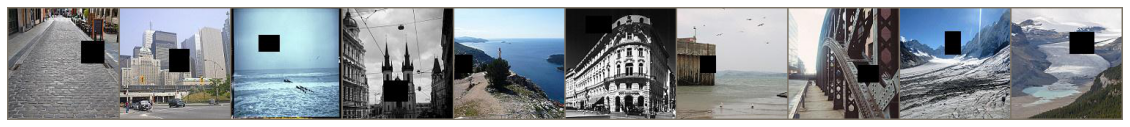

In [50]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:10], nrow = 10))

# Define a model


## Training the model

## Plotting results

In [ ]:
#@title Util Functions

def plot_results(results, name):
  train_accuracy = results['train acc'].values
  test_accuracy = results['test acc'].values

  train_loss = results['train loss'].values
  test_loss = results['test loss'].values

  figureName = name +"_accuracy" # change figure name

  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)
  ax1.plot(results['epoch'].values, train_accuracy, label='train', color='r', marker='s', lw=3)
  ax1.plot(results['epoch'].values, test_accuracy, label='test', color='b', marker='o', lw=3)
  ax1.legend()
  ax1.set_ylim([0,100])
  ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
  ax2.plot(results['epoch'].values, train_loss, label='train', color='r', marker='s', lw=3)
  ax2.plot(results['epoch'].values, test_loss, label='test', color='b', marker='o', lw=3)
  ax2.legend()
  ax2.set(xlabel="Epochs", ylabel="CrossEntropy Loss")
  fig.savefig(f'./results/{figureName}.png')
  plt.show()
